In [12]:
import matplotlib.pyplot as plt
import numpy as np

In [13]:
def x3d(t, params):
    """Designed function for x3"""
    N = params.shape[-1]
    trig_array = [0] * N
    for i in range(N):
        n = (i + 1) // 2
        if i == 0:
            trig_array[i] = np.ones(len(t))
        elif i % 2 == 1:
            trig_array[i] = np.sin(n * t)
        else:   # i % 2 == 0
            trig_array[i] = np.cos(n * t)
    return np.dot(params, trig_array)

In [14]:
def x3dprime(t, params):
    """First derivative of x3d"""
    N = params.shape[-1]
    trig_array = [0] * N
    for i in range(N):
        n = (i + 1) // 2
        if i == 0:
            trig_array[i] = np.zeros(len(t))
        elif i % 2 == 1:
            trig_array[i] = n * np.cos(n * t)
        else:   # i % 2 == 0
            trig_array[i] = n * -np.sin(n * t)
    return np.dot(params, trig_array)

In [15]:
def obj(t, params):
    """Objective function to be minimized"""
    wder_min_w = (- x3dprime(np.array([0]), params) + x3d(np.array([0]), params)) * np.exp(-t)
    x1 = wder_min_w + x3dprime(t, params) - x3d(t, params)
    diff = np.abs(x1 - np.sin(t))
    error = 0
    for i in range(diff.shape[1] - 1):
        error += (diff[:,i+1] + diff[:,i]) * (t[i+1] - t[i]) / 2
    return error

In [16]:
def PSO(obj, p_num, N, scale, w=1, r=0.99, c1=1, c2=1, eps=1e-5, 
        early_stopping=100, max_iter=1000, verbose=True, random_state=None):
    """Main algorithm"""
    
    # initialize
    np.random.seed(random_state)
    params_num = 2 * N + 1
    p = np.random.normal(scale=scale, size=(p_num, params_num))
    v = np.random.normal(scale=scale, size=(p_num, params_num))
    t = np.linspace(0, 4 * np.pi, 101)
    error = obj(t, p)
    pbest = p.copy()
    gbest = p[error.argmin()]
    best_params = [gbest]
    e = [error.min()]
    iter_num = 0
    count = 0
    if verbose == True:
        if len(gbest) <= 7:
            print(f'Initial condition:   params = {gbest}\n\t\t     error = {e[-1]:.4f}\n')
        else:
            print(f'Initial condition:\terror = {e[-1]:.4f}\n')
    
    # main algorithm
    while error.min() > eps and iter_num < max_iter and count < early_stopping:
        # create random numbers, used for updating particle position
        r1 = np.random.uniform(size=(params_num))
        r2 = np.random.uniform(size=(params_num))
        r1 = np.tile(r1, p_num).reshape(p_num, -1)
        r2 = np.tile(r2, p_num).reshape(p_num, -1)
        # update particle position
        v = w * v + c1 * r1 * (pbest - p) + c2 * r2 * (gbest - p)
        w = w * r
        p = p + v
        # calculate error
        error = obj(t, p)
        errorbest = obj(t, pbest)
        # update global best
        gbest = p[error.argmin()]
        # update personal best
        min_idx = np.array([error, errorbest]).argmin(axis=0)
        for i, idx in enumerate(min_idx):
            if idx == 0: pbest[i,:] = p[i,:].copy()
        # update tabulation
        iter_num += 1
        if error.min() >= e[-1]:
            count += 1
        else:
            count = 0
        e.append(error.min())
        best_params.append(gbest)
        # print result in terminal
        if verbose:
            if len(gbest) <= 7:
                print(f'Iteration: {iter_num}\tbest params = {gbest}\n\t\terror = {e[-1]:.4f}')
            else:
                print(f'Iteration: {iter_num}\terror = {e[-1]:.4f}')
    
    # in case max iteration reached
    if iter_num == max_iter:
        print(iter_num, 'maximum iterations reached!',
              'Try increasing max_iter or adjusting PSO parameters for better result.')
    
    # cut tabulation for early stopping
    if count == early_stopping:
        iter_num = iter_num - count
        best_params = best_params[:-early_stopping]
        e = e[:-early_stopping]
    
    # return the number of iterations needed, the best parameters, and error
    return iter_num, np.array(best_params), np.array(e)

Initial condition:   params = [ 0.09495541 -0.1484898  -0.25539211  0.09343199 -0.13668787 -0.02247654
 -0.1170113 ]
		     error = 5.1687

Iteration: 1	best params = [ 0.0927755  -0.21362726 -0.27093549  0.03259867 -0.07809236 -0.06604722
 -0.05491775]
		error = 4.0092
Iteration: 2	best params = [ 0.05924213 -0.60831061 -0.44058426  0.00973174 -0.1110429  -0.10339552
  0.00466473]
		error = 3.6121
Iteration: 3	best params = [ 0.03633298 -0.41886206 -0.51639705  0.01121816 -0.02136765  0.01099861
  0.02811054]
		error = 1.2643
Iteration: 4	best params = [ 0.02228551 -0.44441899 -0.56194997 -0.02799135 -0.00318641  0.04019016
 -0.01437692]
		error = 1.2772
Iteration: 5	best params = [-0.02058441 -0.48073809 -0.75248233 -0.05540162 -0.03671896  0.00695582
 -0.0454124 ]
		error = 2.7673
Iteration: 6	best params = [-0.01643002 -0.58378026 -0.62955889  0.01268006  0.02813037  0.02213365
 -0.02471005]
		error = 1.9027
Iteration: 7	best params = [-0.04396211 -0.49502018 -0.57084917 -0.0138530

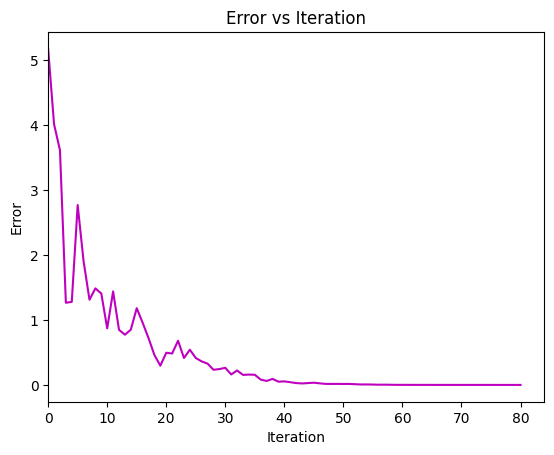

In [17]:
k, best_params, error = PSO(obj, p_num=800, N=3, scale=0.1, random_state=42)
plt.plot(error, c='m')
plt.title('Error vs Iteration')
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.xlim(0)
plt.show()

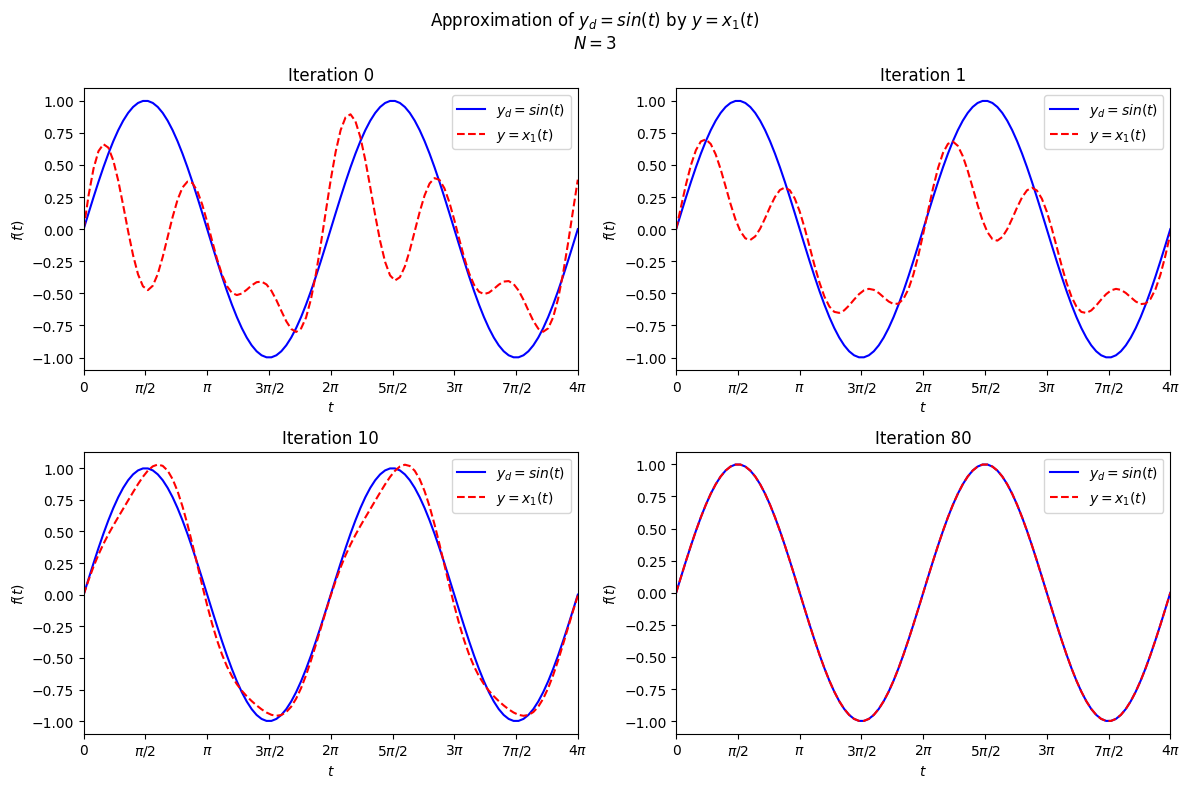

In [18]:

from basic_units import radians, degrees, cos

def sin(x):
    if np.iterable(x):
        return [np.sin(val.convert_to(radians).get_value()) for val in x]
    else:
        return np.sin(x.convert_to(radians).get_value())
    
def plot_result(k, best_params, N):
    t = np.linspace(0, 4 * np.pi, 101)
    x = t * radians
    plt.figure(figsize=(12,8))
    iter_choice = [0, k // 64, k // 8, k]
    for ax, i in enumerate(iter_choice):
        p = best_params[i]
        wder_min_w = (- x3dprime(np.array([0]), p) + x3d(np.array([0]), p)) * np.exp(-t)
        x1 = wder_min_w + x3dprime(t, p) - x3d(t, p)
        plt.subplot(2, 2, ax+1)
        plt.plot(x, sin(x), 'b', xunits=radians)
        plt.plot(x, x1, 'r--', xunits=radians)
        plt.title(f'Iteration {i}')
        plt.xlabel('$t$')
        plt.ylabel('$f(t)$')
        plt.xlim(0, 4 * np.pi)
        plt.legend(['$y_d = sin(t)$', '$y = x_1(t)$'], loc='upper right')
    
    plt.suptitle(f'Approximation of $y_d = sin(t)$ by $y = x_1(t)$\n$N = {N}$')
    plt.tight_layout()
    plt.show()

plot_result(k, best_params, 3)

In [19]:
def plot_average_result(param, N):
    t = np.linspace(0, 4 * np.pi, 101)
    x = t * radians
    
    p = param.mean(axis=0)
    wder_min_w = (- x3dprime(np.array([0]), p) + x3d(np.array([0]), p)) * np.exp(-t)
    x1 = wder_min_w + x3dprime(t, p) - x3d(t, p)
    plt.plot(x, sin(x), 'b', xunits=radians)
    plt.plot(x, x1, 'r--', xunits=radians)
    plt.title(f'Average Approximation after Running {len(param)} Times\n$N = {N}$')
    plt.xlabel('$t$')
    plt.ylabel('$f(t)$')
    plt.xlim(0, 4 * np.pi)
    plt.legend(['$y_d = sin(t)$', '$y = x_1(t)$'], loc='upper right')
    plt.show()

trials = 100

Case 1: N = 3 and scaling = 0.10

Average number of iterations: 78.23
Average parameters found    : [-1.96148263e-08 -5.00000024e-01 -4.99999977e-01  8.69648213e-09
  1.59648819e-08 -2.74475805e-09 -2.00850658e-09]
Average errors              : 4.663474179374997e-07


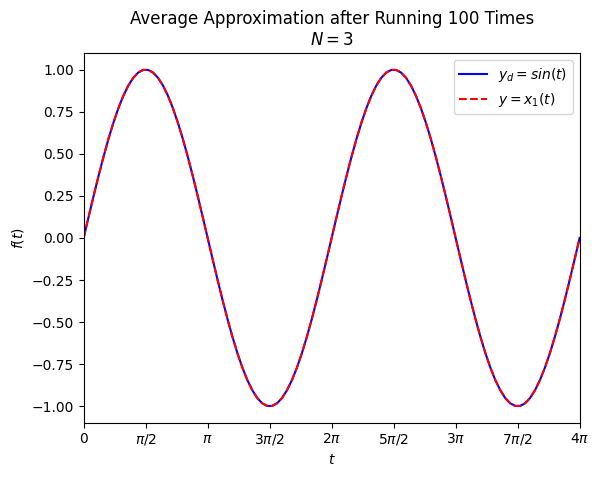

In [20]:
ks = np.zeros(trials)
best = np.zeros((trials, 7))
errors = np.zeros(trials)
for i in range(trials):
    k, best_params, error = PSO(obj, p_num=800, N=3, scale=0.1, verbose=False, random_state=i)
    ks[i] = k
    best[i] = best_params[-1]
    errors[i] = error[-1]

t = np.linspace(0, 4 * np.pi, 101)
p = best.mean(axis=0)
print(f'Average number of iterations: {np.array(ks).mean()}')
print(f'Average parameters found    : {p}')
print(f'Average errors              : {obj(t, p.reshape(1, -1)).item(0)}')
plot_average_result(best, 3)

Case 2: N = 6 and scaling = 0.03

Average number of iterations: 157.02
Average parameters found    : [ 2.77669888e-04 -5.00028298e-01 -4.99962314e-01 -2.07214623e-05
  1.35488131e-04 -8.17892383e-05  3.02623358e-05  2.21678019e-05
  1.48189366e-05 -1.27103542e-06  1.01399954e-05 -1.00090756e-05
 -1.85610973e-06]
Average errors              : 0.003318788381398109


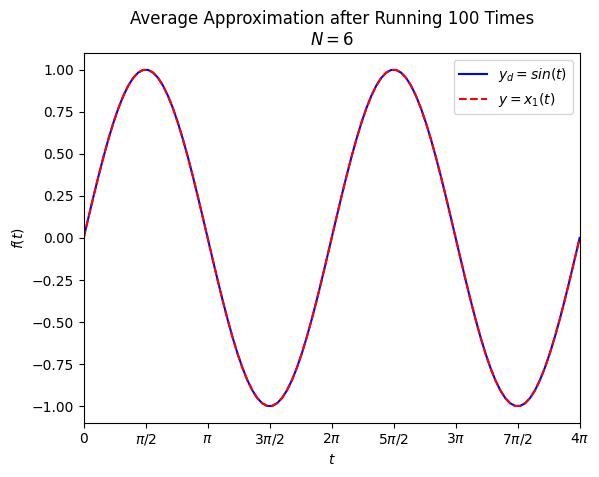

In [21]:
ks = np.zeros(trials)
best = np.zeros((trials, 13))
errors = np.zeros(trials)
for i in range(100):
    k, best_params, error = PSO(obj, p_num=800, N=6, scale=0.03, verbose=False, random_state=i)
    ks[i] = k
    best[i] = best_params[-1]
    errors[i] = error[-1]

t = np.linspace(0, 4 * np.pi, 101)
p = best.mean(axis=0)
print(f'Average number of iterations: {np.array(ks).mean()}')
print(f'Average parameters found    : {p}')
print(f'Average errors              : {obj(t, p.reshape(1, -1)).item(0)}')
plot_average_result(best, 6)